# Cross-slope section

We compute a cross-slope section of fields through gridded data in ACCESS-OM2-01 using the  `metpy.interpolate.cross_section` function; see https://unidata.github.io/MetPy/latest/examples/cross_section.html#sphx-glr-examples-cross-section-py.

Load modules

In [1]:
from dask.distributed import Client
import numpy as np
import xarray as xr
import xgcm
import intake

from metpy.interpolate import cross_section

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Start a cluster with multiple cores

In [2]:
client = Client(threads_per_worker = 1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39849 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39849/status,
Dashboard: /proxy/39849/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39385,Workers: 7
Dashboard: /proxy/39849/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:40939,Total threads: 1
Dashboard: /proxy/44033/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:40657,


Open the Intake Catalog

In [3]:
catalog = intake.cat.access_nri

In [4]:
depth = 3000 # metres

Pick shelf coordinates

In [5]:
# OM2 longitude coordinates run from  [-280, 80] to [-180, 180] - so we need to add 100.
shelf_coord = (-62,   -60 + 100)
deep_coord  = (-56.5, -59 + 100)

Load velocity and bathymetry data

In [6]:
# Select data in the southern part of the Southern Ocean
lat_slice = slice(-80, -59)

# We use a time-mean from some output from the RYF run
expt = '01deg_jra55v13_ryf9091'

# Select the datastore for the experiment
esm_datastore = catalog[expt]

# We want to limit our date range to the 1950s.
# (If you were a cosima_cookbook user, this would have been `start_time = '1950-01-31 00:00:00'` and `end_time = '1959-12-31 00:00:00'`)
# With the catalog, we use the following regular expression to filte on date - it says "find me anything where the date starts with '1950/1951.../1959'":
# See also https://docs.python.org/3/library/re.html
date_str = '^195[0-9].*'

# Import bathymetry as a data array
hu = esm_datastore.search(variable='hu',start_date=date_str).to_dask()['hu']
hu = hu.sel(yu_ocean=lat_slice) # Select our lat slice

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:280: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


In [7]:
# Load density and potential temperature.

rho_temp_datastore = esm_datastore.search(
    variable=["pot_rho_2","pot_temp"], # We can search for these together by passing a list to variable - it's faster that doing it separately.
    start_date=date_str,
    frequency="1mon",
    variable_cell_methods="time: mean"
)

rho_temp_dataset = rho_temp_datastore.to_dask(xarray_open_kwargs={"chunks": {}, "decode_timedelta" : False}) # Turn off chunking (unnecessary) & suppress useless warnings

pot_rho_2 = rho_temp_dataset["pot_rho_2"]
pot_temp = rho_temp_dataset["pot_temp"]

In [8]:
# We're also gonna need xu_ocean, xt_ocean, yu_ocean, and yt_ocean - so we search for them all at once too
grid_datastore = esm_datastore.search(
    variable=["xt_ocean","yt_ocean","xu_ocean", "yu_ocean"], 
    start_date=date_str,
    frequency="1mon",
    file_id="ocean", # If we don't add this, we will get two datasets back.
)
grid = grid_datastore.to_dask(xarray_open_kwargs={"decode_timedelta" : False}) # Suppress some annoying warnings. 

In [9]:
# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds = xr.merge(
    [
        pot_temp.sel(yt_ocean=lat_slice).sel(st_ocean=slice(0, depth)),
        grid.sel(yu_ocean=lat_slice).sel(yt_ocean=lat_slice)
    ]
)

ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid_depth = xgcm.Grid(ds, periodic=['X'])
grid_depth

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> outer
  * outer    yu_ocean --> center

Take time mean for density and temperature

In [10]:
# Make coordinate range selections before taking mean - it'll be faster!
pot_rho_2 = pot_rho_2.sel(yt_ocean = lat_slice).sel(st_ocean=slice(0, depth))
pot_rho_2 = pot_rho_2.mean(dim = 'time')

In [11]:
pot_temp = pot_temp.sel(yt_ocean = lat_slice).sel(st_ocean=slice(0, depth))
pot_temp = pot_temp.mean(dim = 'time')

Now we make the cross sections using the cross_section function of metpy

In [12]:
#choosing number of steps in cross section
step_no = 400

# Create dataset
ds_pot_rho_2 = xr.Dataset({"pot_rho_2": pot_rho_2, "lat": pot_rho_2.yt_ocean, "lon": pot_rho_2.xt_ocean})

# Interpolate to xu_ocean and yu_ocean
# Rename coordinate names
ds_pot_rho_2 = ds_pot_rho_2.rename({'xt_ocean': 'x', 'yt_ocean': 'y'})

# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
ds_pot_rho_2['x'] = ds_pot_rho_2['x'] + 100
ds_pot_rho_2['x'].attrs = pot_rho_2['xt_ocean'].attrs

# MetPy parsing
pot_rho_2_parsed = ds_pot_rho_2.metpy.parse_cf('pot_rho_2', coordinates={'y': 'y', 'x': 'x'})

pot_rho_2_section = cross_section(pot_rho_2_parsed,
                                  start=(shelf_coord[0], shelf_coord[1]),
                                  end=(deep_coord[0], deep_coord[1]),
                                  steps = step_no,
                                  interp_type='linear')

In [13]:
# Create dataset
ds_pot_temp= xr.Dataset({"pot_temp": pot_temp, "lat": pot_temp.yt_ocean, "lon": pot_temp.xt_ocean})

# Interpolate to xu_ocean and yu_ocean
# Rename coordinate names
ds_pot_temp = ds_pot_temp.rename({'xt_ocean': 'x', 'yt_ocean': 'y'})

# Convert longitude from ACCESS-OM2 range of [-280, 80] to [-180, 180] which is what metpy expects.
ds_pot_temp['x'] = ds_pot_temp['x'] + 100
ds_pot_temp['x'].attrs = pot_temp['xt_ocean'].attrs

# MetPy parsing
pot_temp_parsed = ds_pot_temp.metpy.parse_cf('pot_temp', coordinates={'y': 'y', 'x': 'x'})
pot_temp_section = cross_section(pot_temp_parsed,
                                 start = (shelf_coord[0], shelf_coord[1]),
                                 end = (deep_coord[0], deep_coord[1]),
                                 steps = step_no,
                                 interp_type = 'linear')

Finally calculate the distance along the transect (for plotting purposes)

In [14]:
# Define number of points you want to interpolate
step_no = 400

# Radius of the Earth
Rearth = 6371 # km

# Difference between points in lat/lon space
dlon = deep_coord[1] - shelf_coord[1]
dlat = deep_coord[0] - shelf_coord[0]

# Calculate distance in km between the two end points
distance_endpoints = Rearth * np.deg2rad(np.sqrt(dlat**2 + (dlon * np.cos(np.deg2rad(np.mean([shelf_coord[0], deep_coord[0]]))))**2))

# Create array with length of step_no
distance_in_km = np.linspace(0, distance_endpoints, step_no)

# Repeat by the number of depth levels
distance_in_km = np.tile(distance_in_km, (len(pot_temp_section.st_ocean), 1))

## Plotting cross-slope section of potential temperature

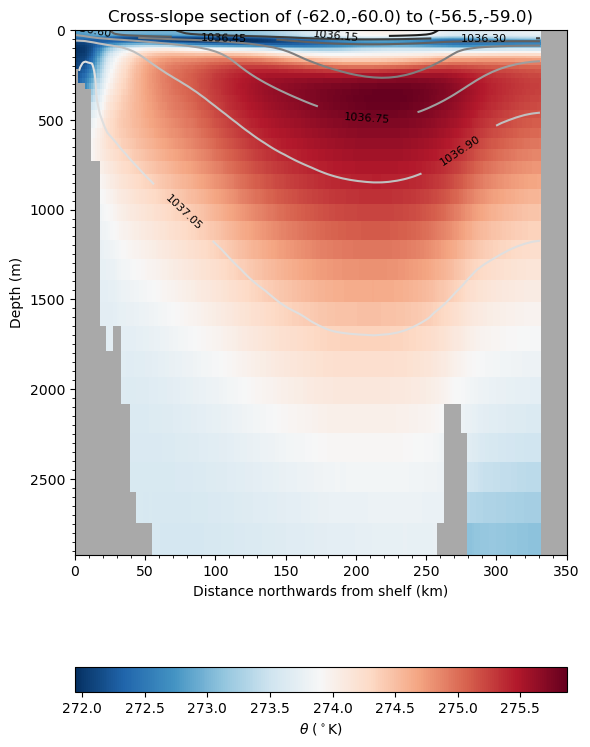

In [15]:
fig, axs = plt.subplots(figsize=(6, 8), sharex = True)

pot_temp_section_top = pot_temp_section.sel(st_ocean=slice(0, 3000))

axs.set_title('Cross-slope section of (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0], shelf_coord[1]-100, deep_coord[0], deep_coord[1]-100))

cmesh = axs.pcolormesh(distance_in_km,
                       pot_temp_section_top.st_ocean.values,
                       pot_temp_section_top.values,
                       cmap = 'RdBu_r')

# Colorbar
cbar = plt.colorbar(cmesh, orientation = 'horizontal')
cbar.set_label(r'$\theta$ ($^\circ$K)')

cs = axs.contour(distance_in_km[0, :],
                 pot_rho_2_section.st_ocean,
                 pot_rho_2_section,
                 cmap = 'gray')

axs.clabel(cs, cs.levels,
           fontsize = 8,
           colors = 'k',
           inline = True,
           use_clabeltext = True)

# Axes
plt.gca().invert_yaxis()
plt.xlim([0, 350])
plt.xlabel('Distance northwards from shelf (km)')
plt.ylabel('Depth (m)')
axs.xaxis.set_minor_locator(MultipleLocator(10))
axs.yaxis.set_minor_locator(MultipleLocator(50))

axs.set_facecolor('darkgrey') # Since our colorbar goes through white, we'll set our mask to grey.
plt.tight_layout();